In [192]:
import torch
import sys
sys.path.append('../')
from pointnet.sh import calc_coeficients,calc_sh,flat2lm_index
from PIL import Image,ImageOps
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [171]:
img = Image.open("Lenna.png")
diff = abs(img.width - img.height)
new_img = Image.new('RGBA', (img.width,img.width), (255,255,255,255))
new_img.paste(img,(0, diff//2))

res = 100
img = new_img.resize((res,res))
img = ImageOps.grayscale(img)
img = torch.from_numpy(np.array(img)).float()/255

In [177]:
l_max = 10
x = torch.arange(0,1,1/res)
grid = torch.dstack(torch.meshgrid((1-x)*torch.pi,x*2*torch.pi,indexing="ij")).flatten(0,1)
Y =calc_sh(l_max,grid)
coefs = calc_coeficients(l_max,grid,img.flatten())
coefs

tensor([ 1.7259e+00,  1.5155e-01, -8.7771e-02, -2.1566e-02,  5.4259e-02,
         7.4674e-02,  1.1484e-02, -1.4110e-01,  1.6831e-01,  1.5626e-01,
        -7.8914e-02,  6.4159e-02,  2.1763e-02,  8.7560e-02,  3.9065e-02,
         3.7054e-02,  3.4900e-02,  1.4122e-02,  2.0880e-02,  4.3081e-02,
        -4.6009e-02, -1.4079e-02, -5.2363e-04,  1.1255e-01, -5.2887e-02,
        -2.6665e-02,  3.6953e-02, -1.7311e-02,  3.6255e-02,  2.0492e-02,
         3.0916e-02,  3.9709e-02, -4.8416e-02, -3.0124e-02, -6.4774e-03,
         4.3897e-02, -7.5499e-02,  4.3780e-02,  2.5805e-02,  9.7903e-02,
         4.9581e-02,  4.5746e-02,  3.3103e-02,  6.2006e-02,  2.9705e-02,
        -2.6710e-02,  4.1433e-02, -9.9908e-03, -7.7880e-02,  2.7561e-02,
        -6.3496e-02,  7.9477e-02,  4.9736e-02, -2.3611e-02,  2.4334e-02,
         2.5495e-02, -4.0060e-02, -1.0958e-02,  1.6714e-03,  5.9063e-02,
        -5.1322e-02,  5.7396e-02,  1.1108e-02,  5.0348e-02, -9.2134e-02,
         4.6654e-03, -3.4475e-02, -2.3459e-02,  5.1

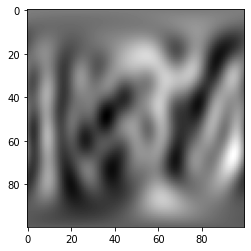

In [178]:

plt.imshow((Y@coefs).reshape(res,res),cmap="gray")

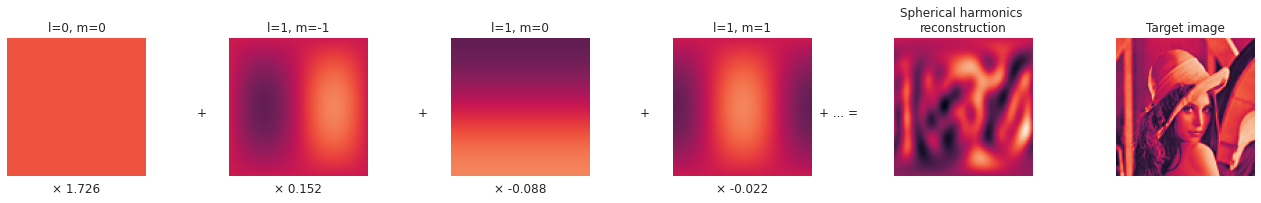

In [203]:
fig,axes = plt.subplots(1,6,figsize=(6*3,1*3),layout="tight")

num_shs = 4

for i in range(num_shs):
    l,m = flat2lm_index(i)
    axes[i].imshow(Y[:,i].reshape(res,res),vmin=-1,vmax=1)
    axes[i].set_title(f"l={l}, m={m}")
    axes[i].axis("off")


    if i >0:
        axes[i].text(-.2, 0.5, '+',
                horizontalalignment='center',
                verticalalignment='top',
                transform=axes[i].transAxes)
    axes[i].text(0.5, -0.05, f"× {round(coefs[i].item()*1000)/1000}",
            horizontalalignment='center',
            verticalalignment='top',
            transform=axes[i].transAxes)

ax_r = axes[num_shs]
ax_t = axes[num_shs+1]
ax_r.imshow((Y@coefs).reshape(res,res))
ax_r.axis("off")
ax_r.set_title("Spherical harmonics \nreconstruction")


axes[num_shs-1].text(1.2, 0.5, '+ ... =',
        horizontalalignment='center',
        verticalalignment='top',
        transform=axes[num_shs-1].transAxes)

ax_t.imshow(img)
ax_t.axis("off")
ax_t.set_title("Target image")

fig.subplots_adjust(
                    wspace=0.4)

plt.savefig("sh_example.pdf")

# SH Model Examples

In [12]:
import torch
from torch.utils.data import DataLoader
import sys
from tqdm import tqdm
sys.path.append('../')
from pointnet.dataset import OctantDataset, collate_batched_point_clouds, lm2flat_index
from pointnet.metrics import camera_color
from pointnet.sh import to_spherical,calc_sh,flat2lm_index

In [6]:
model = torch.jit.load("../logs/8192 octants l=4 rgb final 2/traced_model_gpu.pt")

In [60]:

batch_size = 64

ds = OctantDataset("../datasets/neuschwanstein/octants_8192max_sh",load_cam_colors=True)

data_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_batched_point_clouds,
    pin_memory=False,
    drop_last=False,
    prefetch_factor=10,
    pin_memory_device="cuda:0",
)
var = []
file_names = []
for i,sample in tqdm(enumerate(data_loader),total=len(data_loader)):
    cam_colors = sample.cam_colors.cuda()
    file_names.extend(sample.pcs.file_names)
    var.append(cam_colors.var(1).max(1).values)

/home/niedermayr/anaconda3/envs/punctum12/lib/python3.10/site-packages/torch/utils/data/dataloader.py:616: UserWarning: pin memory device is set and pin_memory flag is not used then device pinned memory won't be usedplease set pin_memory to true, if you need to use the device pin memory
  warnings.warn(warn_msg)
100%|██████████| 1645/1645 [01:31<00:00, 18.07it/s]


In [91]:
samples = [file_names[i] for i in torch.cat(var).topk(batch_size*500).indices[torch.randperm(batch_size)]]

In [92]:
batch = collate_batched_point_clouds([ds.load_fn(fn) for fn in samples])

In [93]:
res = 128
l_max = 4
x = torch.arange(0,1,1/res)
grid = torch.dstack(torch.meshgrid((1-x)*torch.pi,x*2*torch.pi,indexing="ij")).flatten(0,1)
Y =calc_sh(l_max,grid)

In [94]:
pred_coefs = model(*batch.pcs.unpack()).detach().cpu()

In [95]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

imgs_target = batch.coefs[:,:lm2flat_index(l_max,l_max)+1].permute(0,2,1)@Y.T
imgs_target = imgs_target.reshape(batch_size,3,res,res).permute(0,2,3,1)

imgs_pred = pred_coefs.permute(0,2,1)@Y.T
imgs_pred = imgs_pred.reshape(batch_size,3,res,res).permute(0,2,3,1)
imgs_pred.shape

torch.Size([64, 128, 128, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


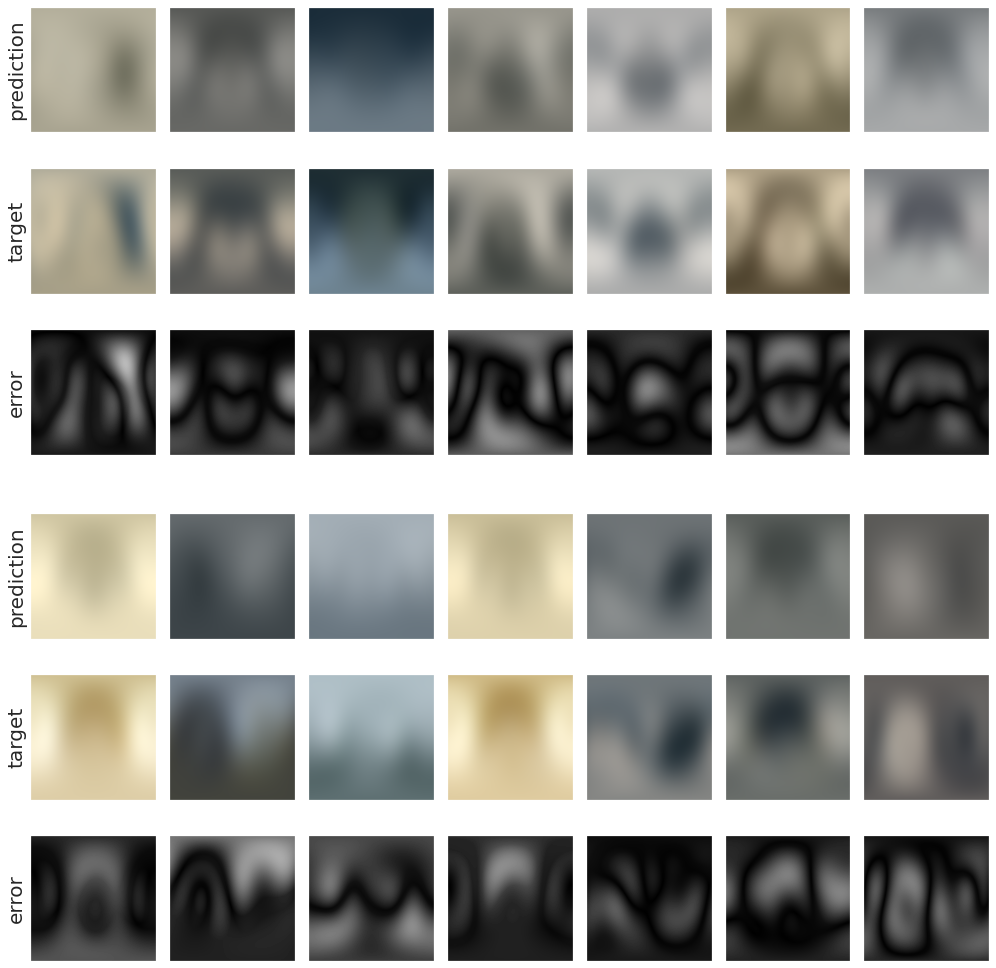

In [190]:
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
cols = 7
rows = 7
fig,axes = plt.subplots(rows,cols,figsize=(cols*2,rows*2),gridspec_kw = {'height_ratios':[5,5,5,.5,5,5,5]})

for ax_row in axes:
    for ax in ax_row:
        ax.grid(False)
        ax.set_xticks([],[])
        ax.set_yticks([],[])
        #ax.axis("off")

for j in range(cols):
    axes[3][j].axis(False)


for i in range((rows+1)//4):
    axes[i*4][0].set_ylabel("prediction",fontsize=20)
    axes[i*4+1][0].set_ylabel("target",fontsize=20)
    axes[i*4+2][0].set_ylabel("error",fontsize=20)
    for j in range(cols):
        ax_pred = axes[i*4][j]
        ax_target = axes[i*4+1][j]
        ax_error = axes[i*4+2][j]

        ax_pred.imshow(imgs_pred[i*cols+j])

        ax_target.imshow(imgs_target[i*cols+j])

        error = (imgs_pred[i*cols+j]-imgs_target[i*cols+j]).abs().mean(-1)
        ax_error.imshow(error,vmin=0,vmax=.2,cmap="gray")

    ax_bar = axes[i*4+2][cols-1]
    
    ax_bar = axes[i*4+2][cols-1]
    #fig.colorbar(scale, ax=ax_error,orientation='vertical',location='right')

plt.tight_layout()
plt.savefig("sh_model_examples.pdf")